# Laboratorium 4

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Rozwiązanie

In [3]:
class Phase:
    def __init__(self, intersects, entries, exits, lines):
        self.intersects = intersects.copy()
        self.entries = entries.copy()
        self.exits = exits.copy()
        self.lines = lines.copy()
    def to_pcoll_list(self):
        return [PointsCollection(self.intersects, color = 'orange'), 
                PointsCollection(self.entries, color = 'green'),
                PointsCollection(self.exits, color = 'red')]
    def to_lcoll_list(self):
        return [LinesCollection(self.lines, color='black')]
    def extend(self, intersects=[], entries=[], exits=[], poly_lines=[]):
        return Phase(self.intersects + intersects,
                     self.entries + entries,
                     self.exits + exits,
                     self.lines + poly_lines)
        
        
    
def phases_to_plot(poly1, poly2, phases):
    scs = []
    lcoll1 = LinesCollection([], color='purple')
    lcoll2 = LinesCollection([], color='pink')
    curr = poly1.first
    while True:
        lcoll1.add([(curr.x, curr.y), (curr.next.x, curr.next.y)])
        curr = curr.next
        if curr == poly1.first:
            break
    
    curr = poly2.first
    while True:
        lcoll2.add([(curr.x, curr.y), (curr.next.x, curr.next.y)])
        curr = curr.next
        if curr == poly2.first:
            break
    for phase in phases:
        scs.append(Scene(phase.to_pcoll_list(), [lcoll1, lcoll2] + phase.to_lcoll_list()))
    return Plot(scs)

In [18]:
ENTRY = 0
EXIT = 1

IN = 0
OUT = 1
ON = 2

UNION = 0
INTERSECTION = 1

def det(a, b, c):
    return a.x * b.y + a.y * c.x + b.x * c.y - b.y * c.x - a.y * b.x - a.x * c.y

class Vertex:
    def __init__(self, x, y, intersect=False, alpha=0):
        self.x = x
        self.y = y
        self.next = None
        self.prev = None
        self.intersect = intersect
        self.entry_exit = None
        self.neighbour = None
        self.alpha = alpha
        self.degen = False

    def next_vertex(self):
        to_return = self.next
        while to_return.intersect and not to_return.degen:
            to_return = to_return.next
        return to_return


class Polygon:
    def __init__(self):
        self.first = None
        
    def copy(self):
        to_return = Polygon()
        v = self.first
        while True:
            to_return.add_vertex(v.x, v.y)
            v = v.next
            if v == self.first:
                break
        return to_return
    
    def to_list(self):
        curr = self.first
        points = []
        while True:
            points.append((curr.x, curr.y))
            curr = curr.next
            if curr == self.first:
                break
        return points
    
    # Adding new vertex at the end of list
    def add_vertex(self, x, y):
        if self.first is None:
            self.first = Vertex(x, y)
            self.first.prev = self.first
            self.first.next = self.first
        else:
            new_vertex = Vertex(x, y)
            new_vertex.next = self.first
            new_vertex.prev = self.first.prev
            self.first.prev.next = new_vertex
            self.first.prev = new_vertex

    # Inserting new vertex between 2 vertices by it's alpha
    def insert_vertex(self, u, v, to_insert):
        curr = u
        while curr.next != v and curr.next.alpha < to_insert.alpha:
            curr = curr.next
        to_insert.next = curr.next
        to_insert.prev = curr
        curr.next.prev = to_insert
        curr.next = to_insert

    # Rotating list to have it represented in opposite direction
    def rotate_list(self):
        curr = self.first
        while True:
            (curr.prev, curr.next) = (curr.next, curr.prev)
            curr = curr.prev
            if curr == self.first:
                break

    # Checks if point lies inside, outside or on the polygon
    # Based on https://www.geeksforgeeks.org/how-to-check-if-a-given-point-lies-inside-a-polygon/
    def test_location(self, vertex):
        curr = self.first
        next = curr.next_vertex()
        count = 0

        while True:
            upper = max([curr, next], key=lambda v: v.y)
            lower = min([curr, next], key=lambda v: v.y)
            if not upper.y == lower.y:
                tmp_det = det(lower, upper, vertex)
                if tmp_det > 0 and (lower.y < vertex.y <= upper.y):
                    count += 1
                elif tmp_det == 0:
                    return ON
            curr = next
            next = next.next_vertex()
            if curr == self.first:
                break

        if count % 2 == 1:
            return IN
        else:
            return OUT

def sgn(a):
    if a < 0:
        return -1
    if a > 0:
        return 1 
    return 0

# Finds intersections between two polygons and inserts them as additional vertices
def det_intersections(poly1, poly2, phases=None):
    p1_curr = poly1.first
    p1_next = p1_curr.next_vertex()
    anyinter = False
    while True:
        p2_curr = poly2.first
        p2_next = p2_curr.next_vertex()
        while True:
            inter = intersect(p1_curr, p1_next, p2_curr, p2_next)
            if inter is not None:
                ((x, y), alpha_p1, alpha_p2) = inter
                if (0 < alpha_p1 < 1) and (0 < alpha_p2 < 1):
                    anyinter = True
                    if phases is not None:
                        phases.append(phases[-1].extend(intersects=[(x,y)]))
                
                    new_vertex_p1 = Vertex(x, y, intersect=True, alpha=alpha_p1)
                    new_vertex_p2 = Vertex(x, y, intersect=True, alpha=alpha_p2)

                    new_vertex_p1.neighbour = new_vertex_p2
                    new_vertex_p2.neighbour = new_vertex_p1

                    poly1.insert_vertex(p1_curr, p1_next, new_vertex_p1)
                    poly2.insert_vertex(p2_curr, p2_next, new_vertex_p2)
                    
                elif (alpha_p1 == 0 or alpha_p1 == 1) and (alpha_p2 == 0 or alpha_p2 == 1):
                    if alpha_p1 == 0:
                        tmp_p1 = p1_curr
                    else:
                        tmp_p1 = p1_next
                    
                    if alpha_p2 == 0:
                        tmp_p2 = p2_curr
                    else:
                        tmp_p2 = p2_next
                    
                    if not tmp_p2.intersect and not tmp_p1.intersect:
                        if sgn(det(tmp_p1.prev, tmp_p1, tmp_p2.next)) == sgn(det(tmp_p1.next, tmp_p1, tmp_p2.prev)):
                            anyinter = True
                            if phases is not None:
                                phases.append(phases[-1].extend(intersects=[(x,y)]))
                            tmp_p1.intersect = True
                            tmp_p2.intersect = True
                            tmp_p1.degen = True
                            tmp_p2.degen = True
                            tmp_p1.neighbour = tmp_p2
                            tmp_p2.neighbour = tmp_p1
            
                elif alpha_p1 == 0 or alpha_p1 == 1: 
                    if alpha_p1 == 0:
                        tmp_p1 = p1_curr
                    else:
                        tmp_p1 = p1_next
                    
                    if not tmp_p1.intersect:
                        if sgn(det(p2_curr, tmp_p1, tmp_p1.next)) == sgn(det(p2_next, tmp_p1, tmp_p1.prev)):
                            anyinter = True
                            if phases is not None:
                                phases.append(phases[-1].extend(intersects=[(x,y)]))
                            tmp_p1.intersect = True
                            tmp_p1.degen = True
                            new_vertex_p2 = Vertex(x, y, intersect=True, alpha=alpha_p2)
                            new_vertex_p2.neighbour = tmp_p1
                            tmp_p1.neighbour = new_vertex_p2
                            poly2.insert_vertex(p2_curr, p2_next, new_vertex_p2)
                            
                elif alpha_p2 == 0 or alpha_p2 == 1:
                    if alpha_p2 == 0:
                        tmp_p2 = p2_curr
                    else:
                        tmp_p2 = p2_next
                    
                    if not tmp_p2.intersect:
                        if sgn(det(p1_curr, tmp_p2, tmp_p2.next)) == sgn(det(p1_next, tmp_p2, tmp_p2.prev)):
                            anyinter = True
                            if phases is not None:
                                phases.append(phases[-1].extend(intersects=[(x,y)]))
                            tmp_p2.intersect = True
                            tmp_p2.degen = True
                            new_vertex_p1 = Vertex(x, y, intersect=True, alpha=alpha_p1)
                            new_vertex_p1.neighbour = tmp_p2
                            tmp_p2.neighbour = new_vertex_p1
                            poly1.insert_vertex(p1_curr, p1_next, new_vertex_p1)
                        

            p2_curr = p2_next
            p2_next = p2_next.next_vertex()
            if p2_curr == poly2.first:
                break
        p1_curr = p1_next
        p1_next = p1_next.next_vertex()
        if p1_curr == poly1.first:
            break
    return anyinter

def intersect(u1, u2, v1, v2):
    px = u1.x
    py = u1.y
    qx = v1.x
    qy = v1.y

    ry = u2.y - u1.y
    rx = u2.x - u1.x
    sy = v2.y - v1.y
    sx = v2.x - v1.x

    rxs = sy * rx - sx * ry
    if rxs == 0:
        return None

    alpha_u = ((qx - px) * sy - (qy - py) * sx) / rxs
    alpha_v = ((qx - px) * ry - (qy - py) * rx) / rxs

    if (0 <= alpha_u <= 1) and (0 <= alpha_v <= 1):
        x = px + alpha_u * rx
        y = py + alpha_u * ry
        return ((x, y), alpha_u, alpha_v)

    return None

# Sets entry_exit parameter for every intersection
def set_vertices(poly1, poly2, phases=None):
    curr = poly1.first
    loc = poly2.test_location(curr)
    while loc == ON:
        curr = curr.next
        loc = poly2.test_location(curr)
    first_vertex = curr
    next_mode = ENTRY if loc == OUT else EXIT
    while True:
        if curr.intersect:
            if phases is not None:
                if next_mode == ENTRY:
                    phases.append(phases[-1].extend(entries=[(curr.x, curr.y)]))
                else:
                    phases.append(phases[-1].extend(exits=[(curr.x, curr.y)]))
            curr.entry_exit = next_mode
            curr.neighbour.entry_exit = next_mode
            next_mode = (next_mode + 1) % 2
        curr = curr.next
        if curr == first_vertex:
            break

# Clipping algorithm based on article https://www.inf.usi.ch/hormann/papers/Greiner.1998.ECO.pdf
# By Gunther Greiner and Kai Hormann
def greiner_hormann(polygon1, polygon2, mode):
    poly1 = polygon1.copy()
    poly2 = polygon2.copy()
    
    # Used to visualisation
    phases = [Phase([],[],[],[])]
    
    # To keep integrity of neighbours' modes we can reverse one of polygons to be represented clockwise
    poly2.rotate_list()
    
    # Polygons are extended by intersection vertices
    # If no intersections are registered algorithm returns suitable polygons
    if not det_intersections(poly1, poly2, phases):
        if mode == UNION:
            if poly2.test_location(poly1.first) == IN:
                polygons_list = [poly2]
            elif poly1.test_location(poly2.first) == IN:
                polygons_list = [poly1]
            else:
                polygons_list = [poly1, poly2]
        
        elif mode == INTERSECTION:
            if poly2.test_location(poly1.first) == IN:
                polygons_list = [poly1]
            elif poly1.test_location(poly2.first) == IN:
                polygons_list = [poly2]
            else:
                polygons_list = []
                
        return (polygons_list, [])
        
    
    # Setting modes for vertices
    set_vertices(poly1, poly2, phases)
        
    # Core algorithm
    polygons_list = []
    curr = poly1.first
    
    # Union mode
    if mode == UNION:
        while True:
            # Not used intersection found which starts a new polygon
            if curr.intersect:
                first_point = curr
                first_point.intersect = False
                first_point.neighbour.intersect = False
                new_poly = Polygon()
                new_poly.add_vertex(curr.x, curr.y)
                act_mode = curr.entry_exit
                while True:
                    # Essential part of the algorithm, going through the edges of new polygon
                    # Way of traversing polygon depends on clipping mode
                    # UNION: From ENTRY backward, from EXIT forward
                    # INTERSECTION: From ENTRY forward, from EXIT backward
                    if act_mode == ENTRY:
                        phases.append(phases[-1].extend(poly_lines=[[(curr.x, curr.y), (curr.prev.x, curr.prev.y)]]))
                        curr = curr.prev
                    else:
                        phases.append(phases[-1].extend(poly_lines=[[(curr.x, curr.y), (curr.next.x, curr.next.y)]]))
                        curr = curr.next
                    if curr == first_point or curr.neighbour == first_point:
                        break
                    new_poly.add_vertex(curr.x, curr.y)
                    if curr.intersect:
                        curr.intersect = False
                        curr.neighbour.intersect = False
                        curr = curr.neighbour
                        act_mode = curr.entry_exit
                polygons_list.append(new_poly)
                curr = first_point.next
            curr = curr.next
            if curr == poly1.first:
                break

    # Intersection mode
    elif mode == INTERSECTION:
        while True:
            if curr.intersect:
                first_point = curr
                first_point.intersect = False
                first_point.neighbour.intersect = False
                new_poly = Polygon()
                new_poly.add_vertex(curr.x, curr.y)
                act_mode = curr.entry_exit
                while True:
                    if act_mode == ENTRY:
                        phases.append(phases[-1].extend(poly_lines=[[(curr.x, curr.y), (curr.next.x, curr.next.y)]]))
                        curr = curr.next
                    else:
                        phases.append(phases[-1].extend(poly_lines=[[(curr.x, curr.y), (curr.prev.x, curr.prev.y)]]))
                        curr = curr.prev
                    if curr == first_point or curr.neighbour == first_point:
                        break
                    new_poly.add_vertex(curr.x, curr.y)
                    if curr.intersect:
                        curr.intersect = False
                        curr.neighbour.intersect = False
                        curr = curr.neighbour
                        act_mode = curr.entry_exit
                polygons_list.append(new_poly)
                curr = first_point.next
            curr = curr.next
            if curr == poly1.first:
                break
    return (polygons_list, phases)

def union(poly1, poly2):
    return greiner_hormann(poly1, poly2, UNION)

def intersection(poly1, poly2):
    return greiner_hormann(poly1, poly2, INTERSECTION)

def animated_operation(poly1, poly2, operation):
    (_, phases) = operation(poly1, poly2)
    return phases_to_plot(poly1, poly2, phases)

In [27]:
def polygons_to_json(polygons, filename):
    scs = [Scene([polygon_to_collections(p)[0]]) for p in polygons]
    pl = Plot(scs)
    file = open(filename, "w")
    file.write(pl.toJson())

def polygons_from_json(filename):
    with open(filename, "r") as file:
        json = file.read()
    pl = Plot(json=json)
    polygons = []
    for scene in pl.scenes:
        new_polygon = Polygon()
        for point in scene.points[0].points:
            new_polygon.add_vertex(point[0], point[1])
        polygons.append(new_polygon)
    return polygons

In [62]:
%matplotlib notebook

import random

def load_polygons(plot):
    polygons = []
    for lcoll in plot.get_added_figure():
        polygons.append(Polygon())
        for line in lcoll.lines:
            polygons[-1].add_vertex(line[0][0], line[0][1])
    return polygons

# Polygon as tuple (PointsCollection, LinesCollection)
def polygon_to_collections(poly):
    color = (random.random(), random.random(), random.random())
    pcoll = PointsCollection([], color=color)
    lcoll = LinesCollection([], color=color)
    curr = poly.first
    while True:
        pcoll.add_points([(curr.x, curr.y)])
        lcoll.add([(curr.x, curr.y), (curr.next.x, curr.next.y)])
        curr = curr.next
        if curr == poly.first:
            break
    return (pcoll, lcoll)

def show_operation(polygon1, polygon2, operation):
    (poly_list, _) = operation(polygon1, polygon2)
    points = []
    lines = []

    for p in poly_list:
        (pcoll, lcoll) = polygon_to_collections(p)
        points.append(pcoll)
        lines.append(lcoll)
    
    scs = [Scene(points, lines)]
    return Plot(scs)

def show_operations(polygon1, polygon2):
    (u_polygons, _) = union(polygon1, polygon2)
    (i_polygons, _) = intersection(polygon1, polygon2)

    u_points = []
    u_lines = []
    i_points = []
    i_lines = []

    for p in u_polygons:
        (pcoll, lcoll) = polygon_to_collections(p)
        u_points.append(pcoll)
        u_lines.append(lcoll)

    for p in i_polygons:
        (pcoll, lcoll) = polygon_to_collections(p)
        i_points.append(pcoll)
        i_lines.append(lcoll)

    (_, lcoll1) = polygon_to_collections(polygon1)
    (_, lcoll2) = polygon_to_collections(polygon2)
    scs = []
    scs.append(Scene([], [lcoll1, lcoll2]))
    scs.append(Scene(u_points, u_lines))
    scs.append(Scene(i_points, i_lines))
    return Plot(scs)

<IPython.core.display.Javascript object>


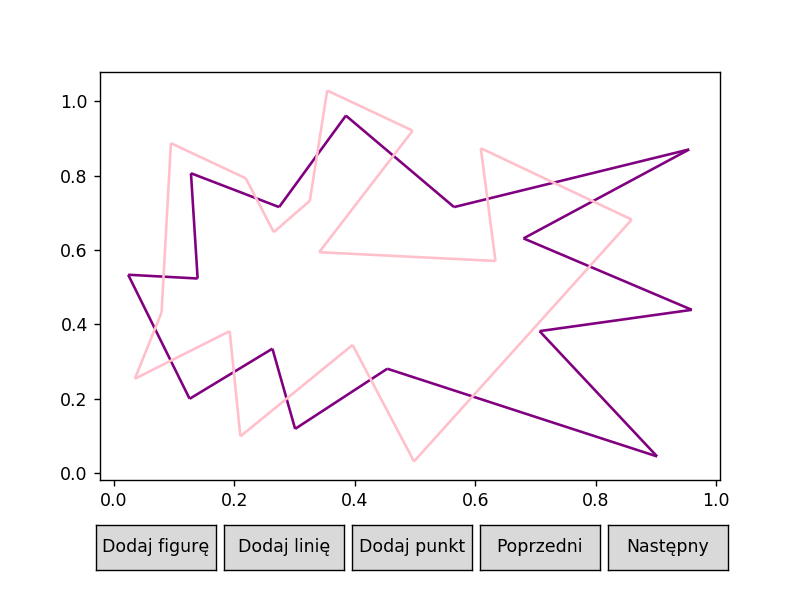

In [43]:
ex_polys = polygons_from_json("ex1.json")
anim = animated_operation(ex_polys[0], ex_polys[1], union)
anim.draw()

<IPython.core.display.Javascript object>


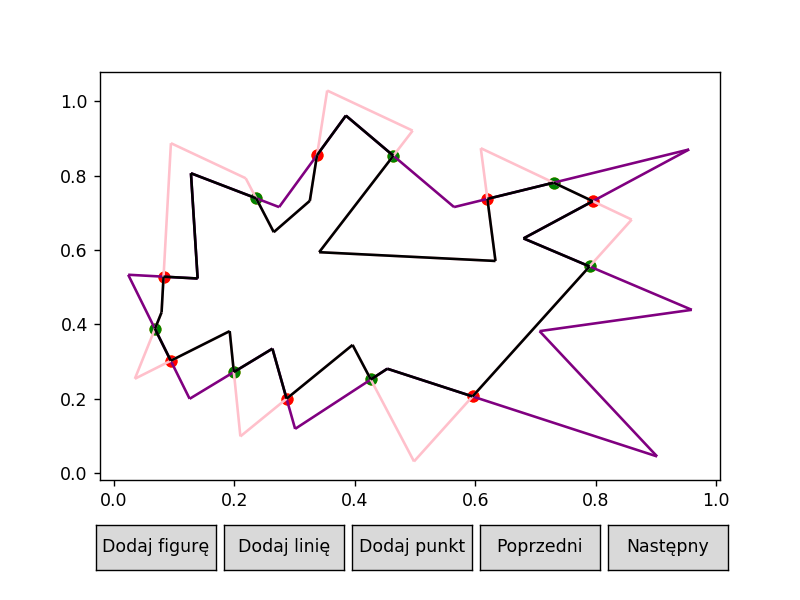

In [45]:
ex_polys = polygons_from_json("ex1.json")
anim = animated_operation(ex_polys[0], ex_polys[1], intersection)
anim.draw()

<IPython.core.display.Javascript object>


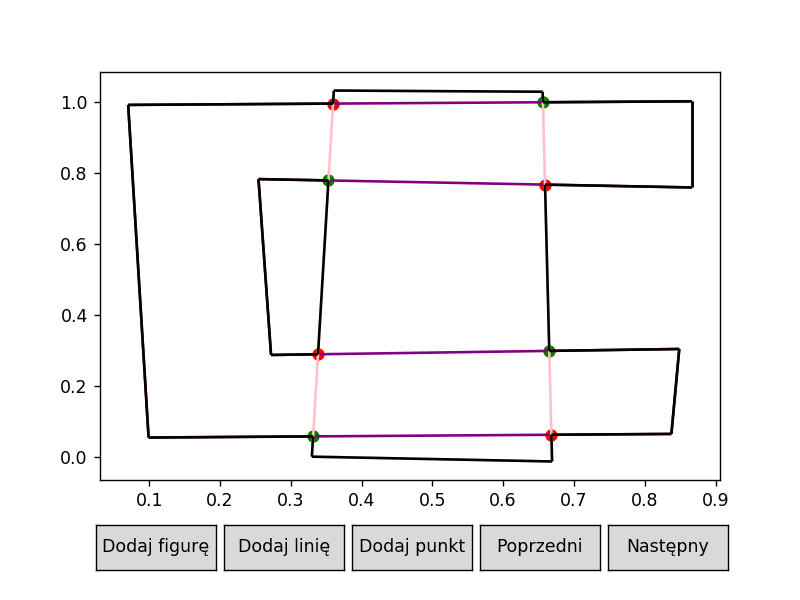

In [53]:
ex_polys = polygons_from_json("ex2.json")
anim = animated_operation(ex_polys[0], ex_polys[1], union)
anim.draw()

<IPython.core.display.Javascript object>


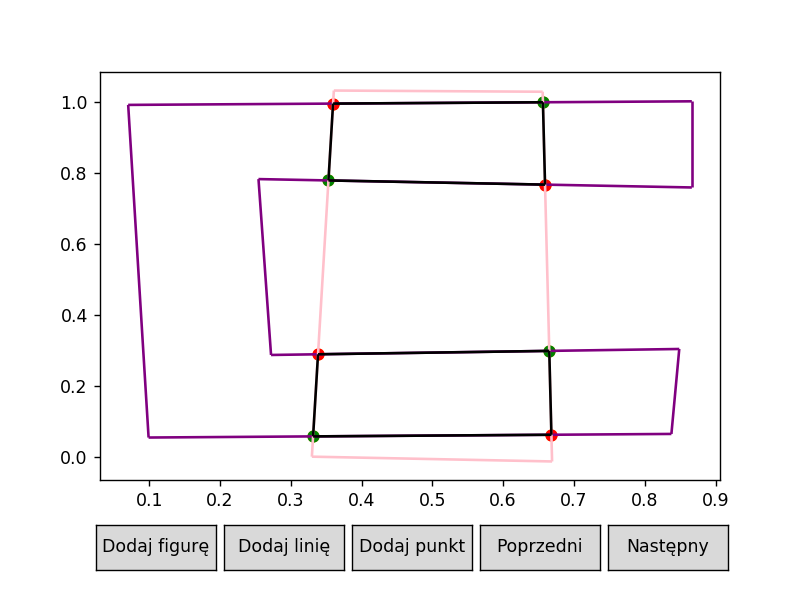

In [52]:
ex_polys = polygons_from_json("ex2.json")
anim = animated_operation(ex_polys[0], ex_polys[1], intersection)
anim.draw()

<IPython.core.display.Javascript object>


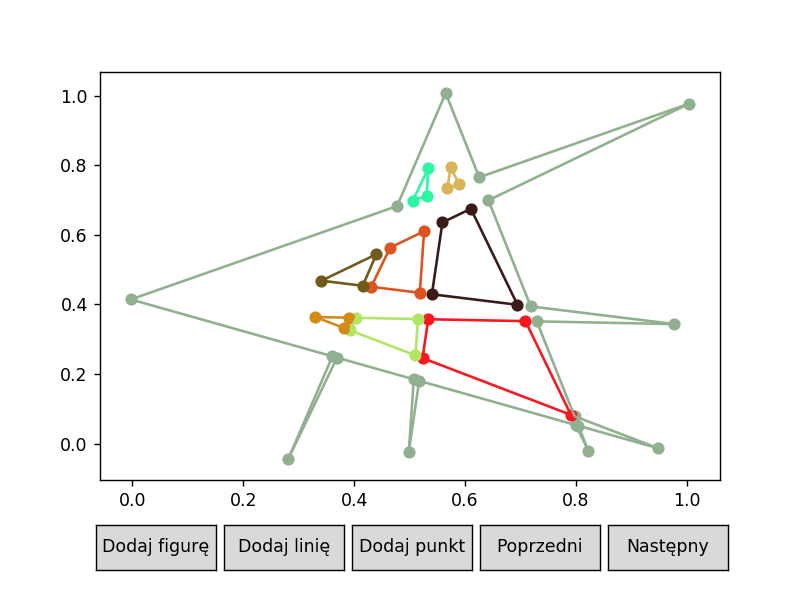

In [63]:
ex_polys = polygons_from_json("ex3.json")
anim = show_operations(ex_polys[0], ex_polys[1])
anim.draw()

<IPython.core.display.Javascript object>


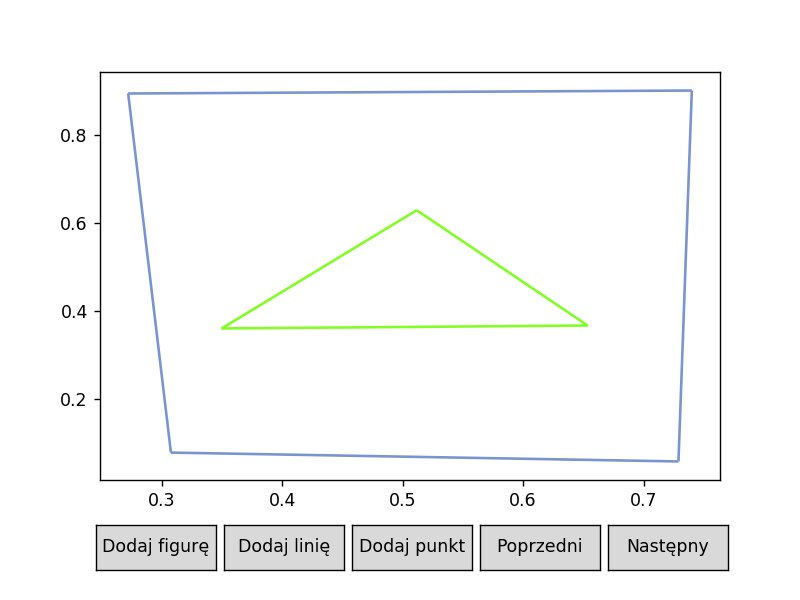

In [67]:
ex_polys = polygons_from_json("inside.json")
anim = show_operations(ex_polys[0], ex_polys[1])
anim.draw()

<IPython.core.display.Javascript object>


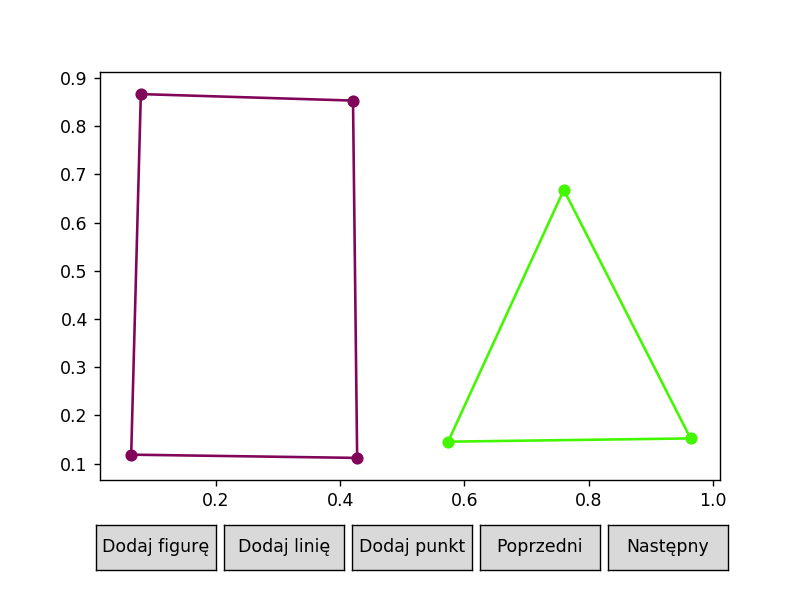

In [71]:
ex_polys = polygons_from_json("separate.json")
anim = show_operations(ex_polys[0], ex_polys[1])
anim.draw()

<IPython.core.display.Javascript object>


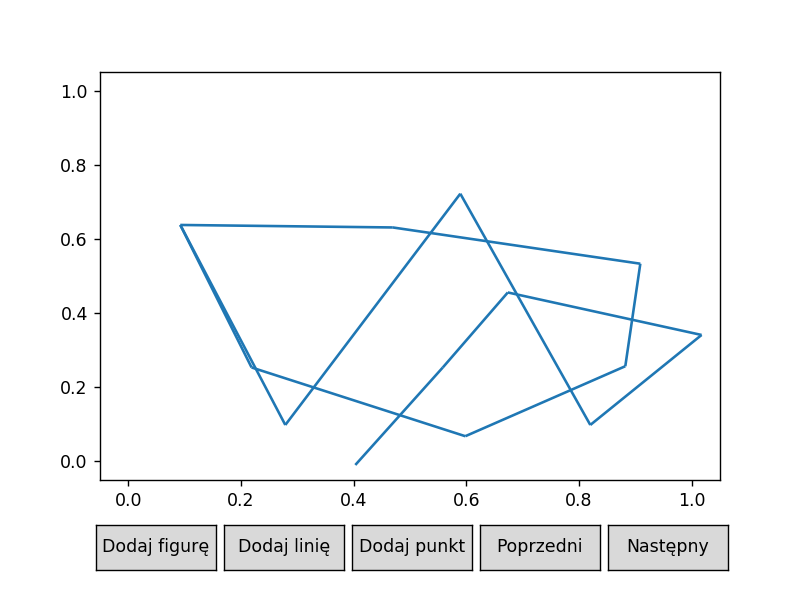

In [74]:
plot = Plot()
plot.draw()

In [ ]:
polygons = load_polygons(plot)